<h1 style="text-align:center; color:blue;">Fitting the model using pygam</h1>

Here we use the dataset located at https://github.com/mfasiolo/electBook/raw/master/data/IrishAgg.RData

In [1]:
import pyreadr
import pygam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests


The IrishAgg dataset is saved as an R dataset and needs to be converted to a data frame that can be read by Python.

In [2]:
import pyreadr
import requests

# GitHub file raw URL
url = 'https://github.com/mfasiolo/electBook/raw/master/data/IrishAgg.RData'  # Ensure the URL points to the raw file

# Download file content
response = requests.get(url)
response.raise_for_status()  # Raise an error if the download fails

# Save content to a temporary file
with open('IrishAgg.RData', 'wb') as file:
    file.write(response.content)

# Load the RData file using pyreadr
result = pyreadr.read_r('IrishAgg.RData')  # Returns a dictionary, keys are object names, values are the corresponding data

# Get the first data object
iragg = result[list(result.keys())[0]]

# Display the first few rows of the dataset
print(iragg.head())
print(type(iragg))

   time       toy  dow   holy  tod  temp            dateTime       dem  dem48  \
0     1  0.986301  Wed  False  0.0   4.0 2009-12-29 23:00:00  1674.398    NaN   
1     2  0.986301  Wed  False  1.0   4.0 2009-12-29 23:30:00  1404.605    NaN   
2     3  0.986301  Wed  False  2.0   4.0 2009-12-30 00:00:00  1180.766    NaN   
3     4  0.986301  Wed  False  3.0   4.0 2009-12-30 00:30:00  1022.626    NaN   
4     5  0.986301  Wed  False  4.0   4.0 2009-12-30 01:00:00   877.018    NaN   

   temp95  
0     4.0  
1     4.0  
2     4.0  
3     4.0  
4     4.0  
<class 'pandas.core.frame.DataFrame'>


In [3]:
subset = iragg.iloc[ :5,:2]
print(subset)

   time       toy
0     1  0.986301
1     2  0.986301
2     3  0.986301
3     4  0.986301
4     5  0.986301


In [4]:
print(iragg.dtypes)

time                 int32
toy                float64
dow               category
holy                  bool
tod                float64
temp               float64
dateTime    datetime64[ns]
dem                float64
dem48              float64
temp95             float64
dtype: object


<h2 style="text-align:center; color:blue;">Data preprocessing</h2>
The data types are shown here. Unfortunately, the pygam module cannot read these types directly as easily as mgcv, so we need to convert the file format (which also means that the accuracy will be reduced).

In [5]:
#change dow to int32 form
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
iragg['dow'] = iragg['dow'].astype(str)  
iragg['dow_encoded'] = label_encoder.fit_transform(iragg['dow'])
iragg.drop('dow', axis=1, inplace=True)  


In [6]:
iragg['timestamp'] = iragg['dateTime'].apply(lambda x: x.timestamp())
iragg.drop('dateTime', axis=1, inplace=True)


Pygam also cannot automatically handle missing data, so one more step is needed to automatically fill it in.

In [7]:
# number of lack data
print(iragg.isnull().sum())
print(iragg.isin([np.inf, -np.inf]).sum())


time            0
toy             0
holy            0
tod             0
temp            0
dem             0
dem48          48
temp95          0
dow_encoded     0
timestamp       0
dtype: int64
time           0
toy            0
holy           0
tod            0
temp           0
dem            0
dem48          0
temp95         0
dow_encoded    0
timestamp      0
dtype: int64


In [8]:
#fill dem48
column_to_fill = 'dem48'

mean_value = iragg[column_to_fill].mean()
iragg[column_to_fill].fillna(mean_value, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_19084\3191371533.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  iragg[column_to_fill].fillna(mean_value, inplace=True)


In [9]:

print(iragg.isnull().sum())

print(iragg.isin([np.inf, -np.inf]).sum())
print(iragg)


time           0
toy            0
holy           0
tod            0
temp           0
dem            0
dem48          0
temp95         0
dow_encoded    0
timestamp      0
dtype: int64
time           0
toy            0
holy           0
tod            0
temp           0
dem            0
dem48          0
temp95         0
dow_encoded    0
timestamp      0
dtype: int64
        time       toy   holy   tod  temp       dem        dem48    temp95  \
0          1  0.986301  False   0.0   4.0  1674.398  1333.366726  4.000000   
1          2  0.986301  False   1.0   4.0  1404.605  1333.366726  4.000000   
2          3  0.986301  False   2.0   4.0  1180.766  1333.366726  4.000000   
3          4  0.986301  False   3.0   4.0  1022.626  1333.366726  4.000000   
4          5  0.986301  False   4.0   4.0   877.018  1333.366726  4.000000   
...      ...       ...    ...   ...   ...       ...          ...       ...   
16794  16795  0.991781  False  43.0   6.0  2314.324  2485.992000  6.719819   
16795  167

<h2 style="text-align:center; color:blue;">GAM model fitting</h2>

In [10]:
selected_columns = ['dem48', 'dow_encoded', 'temp','temp95','tod','toy']

In [11]:
from pygam import LinearGAM, s
gam_model = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)).fit(iragg[selected_columns], iragg['dem'])
gam_model.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     89.9092
Link Function:                     IdentityLink Log Likelihood:                               -182005.7703
Number of Samples:                        16799 AIC:                                            364193.359
                                                AICc:                                          364194.3592
                                                GCV:                                            20435.6121
                                                Scale:                                          20238.8357
                                                Pseudo R-Squared:                                   0.9448
Feature Function                  Lam

C:\Users\User\AppData\Local\Temp\ipykernel_19084\2138586005.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_model.summary()


AIC is 364193, larger than mgcv in R gives (around 210000)
At the same time, pay attention to the effective degree of freedom parameter. The two models given by mgcv are 41 and 66 respectively, while here we get 89. This means that the model is more complex. At the same time, we get lower accuracy based on AIC, which obviously means that pygam is less efficient than mgcv.

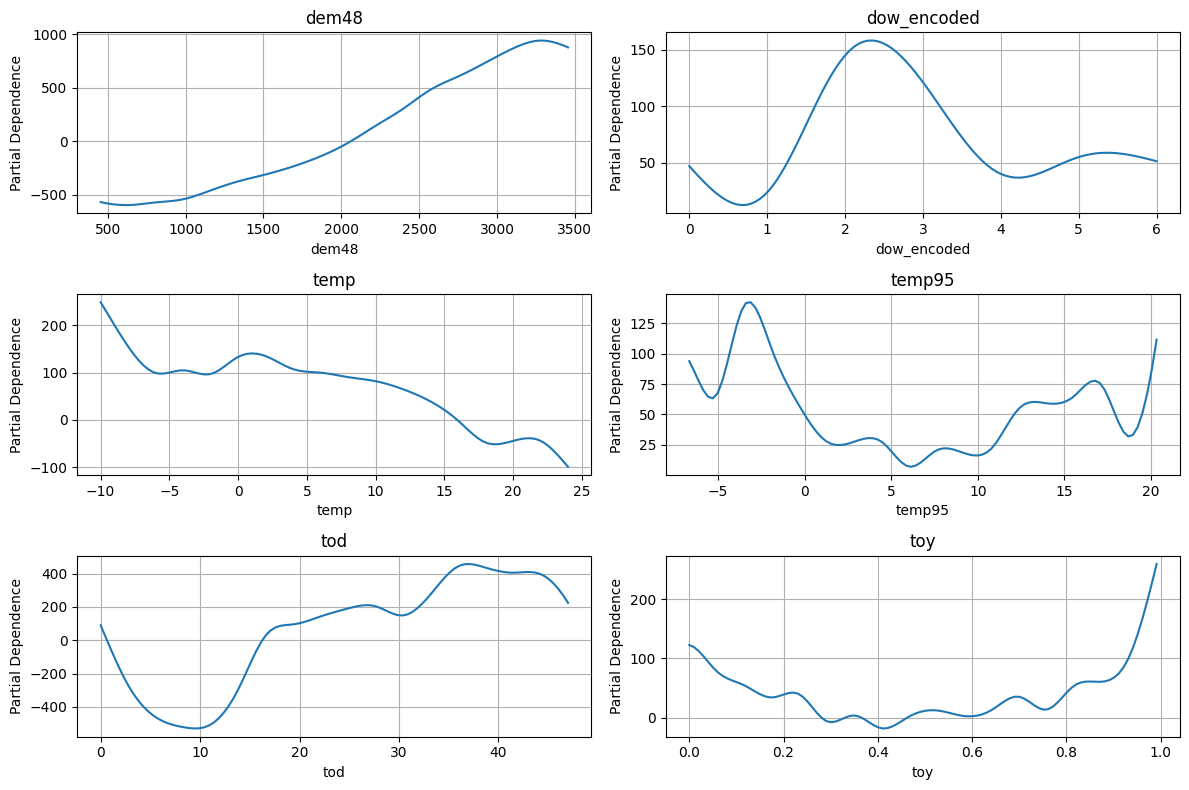

In [12]:
# plot
plt.figure(figsize=(12, 8))
for i, term in enumerate(gam_model.terms):
    if term.isintercept:
        continue
    plt.subplot(3, 2, i+1)
    XX = gam_model.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam_model.partial_dependence(term=i, X=XX))
    plt.title(selected_columns[i])
    plt.xlabel(f'{selected_columns[i]}')
    plt.ylabel('Partial Dependence')
    plt.grid(True)

plt.tight_layout()
plt.show()

Pygam seems unable to fine-tune the model parameters, which makes me only generate this one model

<h2 style="text-align:center; color:blue;">MSE and R^2</h2>


In [13]:
print(type(gam_model))

<class 'pygam.pygam.LinearGAM'>


In [14]:
X_new = iragg[selected_columns]  # Replace selected_columns with the appropriate columns used during training
# Perform prediction
predictions = gam_model.predict(X_new)
print("Predictions:")
print(predictions)

Predictions:
[1526.47549781 1386.40016307 1254.62226238 ... 2365.77642561 2179.18592322
 1989.78391054]


In [15]:
from sklearn.metrics import mean_squared_error, r2_score

true_value=iragg['dem']
def evaluate_model(true_value, predictions):
    # MSE
    mse = mean_squared_error(true_value, predictions)
    
    # R^2
    r2 = r2_score(true_value, predictions)
    
    return mse, r2

# evaluate model
mse, r2 = evaluate_model(true_value, predictions)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Coefficient of Determination (R^2): {r2}")


Mean Squared Error (MSE): 20130.516305820696
Coefficient of Determination (R^2): 0.9448418904728135


In [16]:
type(iragg)

pandas.core.frame.DataFrame